Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [6]:
apartments = df
apartments.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
apartments.shape

(48817, 34)

In [8]:
apartments.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [9]:
apartments.isnull().sum()

bathrooms                  0
bedrooms                   0
created                    0
description             1425
display_address          133
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
dtype: int64

In [10]:
# Which variables are correlated with each other?
correlated = apartments.corr()

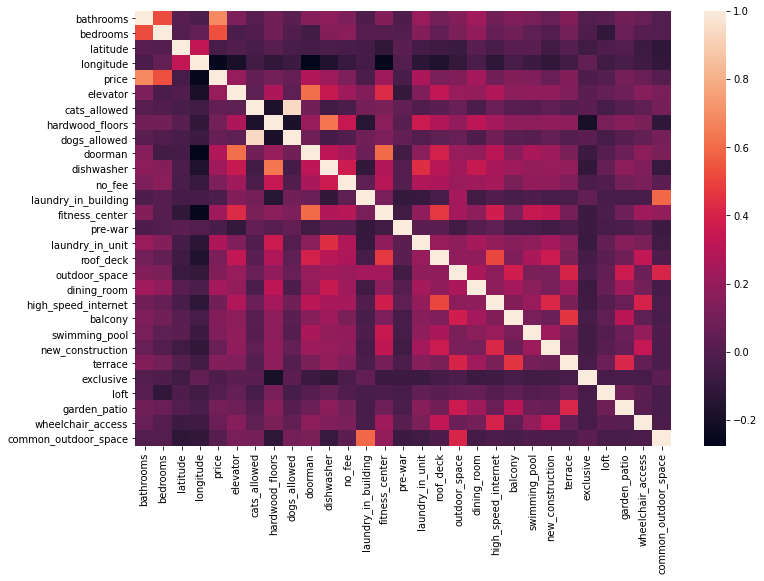

In [11]:
# Display correlation as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlated);

In [12]:
# which variables are most correlated with price?
correlated['price'].sort_values(ascending=False)

price                   1.000000
bathrooms               0.687296
bedrooms                0.535503
doorman                 0.276215
laundry_in_unit         0.271195
dining_room             0.242911
fitness_center          0.228775
dishwasher              0.223899
elevator                0.207169
terrace                 0.145973
outdoor_space           0.142146
balcony                 0.139140
swimming_pool           0.134513
no_fee                  0.132240
roof_deck               0.122929
garden_patio            0.103672
hardwood_floors         0.101503
high_speed_internet     0.090269
wheelchair_access       0.072517
new_construction        0.071431
dogs_allowed            0.060401
cats_allowed            0.051453
common_outdoor_space    0.011517
loft                    0.007100
exclusive              -0.013251
laundry_in_building    -0.019417
pre-war                -0.029122
latitude               -0.036286
longitude              -0.251004
Name: price, dtype: float64

In [13]:
# Create feature: number of bedrooms + number of bathrooms
# Add column to apartments dataset
apartments['bed_bath'] = apartments['bathrooms'] + apartments['bedrooms']
apartments.sample(3)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bed_bath
34652,1.0,1,2016-05-08 03:54:00,,Hudson St,40.7355,-74.0058,4295,560 Hudson St,low,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
26879,1.0,2,2016-05-06 05:23:40,Available for immediately move-in only. True 2...,37a Bedford Street,40.7297,-74.0040,3550,37a Bedford Street,medium,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
25801,1.0,1,2016-05-07 02:32:45,This East Village one bedroom apartment has qu...,Avenue A,40.7277,-73.9826,2345,153 Avenue A,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.0


In [14]:
# Create feature: bedroom to bathroom ratio
# Add column to apartments dataset
apartments['bath_to_bed'] = apartments['bedrooms'] / apartments['bathrooms']
apartments.sample(3)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bed_bath,bath_to_bed
29260,1.0,2,2016-05-28 03:07:57,NO FEE@@@NO FEE@@@NO FEE@@@This fantastic Murr...,E 34th St.,40.7444,-73.9754,4200,300 E 34th St.,low,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0,2.0
42374,2.0,2,2016-04-20 03:04:37,Newly renovated large 1 bedroom duplex apartme...,E 5 Street,40.7243,-73.9837,3450,516 E 5 Street,medium,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.0,1.0
1301,1.0,0,2016-04-21 01:40:01,NaN,Fifth Avenue,40.7332,-73.9960,3100,24 Fifth Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0


In [15]:
# remove na values
apartments = apartments.replace([np.inf, -np.inf], np.nan)

In [16]:
# drop NaN
apartments.dropna(subset=['bath_to_bed'], inplace=True)

In [17]:
apartments.isnull().sum()

bathrooms                  0
bedrooms                   0
created                    0
description             1425
display_address          133
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
bed_bath      

In [18]:
# Declare the target variable
y = apartments['price']

In [19]:
# Declare feature variables
X = apartments[['bed_bath', 'bath_to_bed']]

In [20]:
# Split the data into two sets
# Train on data from April & May 2016
# Test on data from June 2016

train = apartments[(apartments['created'] > '2016-04-01') & (apartments['created'] <'2016-05-31')]
test = apartments[(apartments['created'] > '2016-06-01') & (apartments['created'] <'2016-06-30')]

In [21]:
test.sample(3)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bed_bath,bath_to_bed
22747,1.0,1,2016-06-12 11:13:45,UPPER WEST SIDE LUXURY!<br /><br />The...,West 71st Street,40.7783,-73.9837,3365,228 West 71st Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0
17120,1.0,0,2016-06-14 15:49:15,"Please call, text or email me ASAP with the ID...",East 71st Street,40.7679,-73.9579,2195,311 East 71st Street,medium,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0
15315,1.0,0,2016-06-08 02:29:15,Large studio layout at a competitive price! F...,W 55th St.,40.7652,-73.9843,2400,300 W 55th St.,low,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0


In [22]:
train.shape, test.shape

((31648, 36), (16860, 36))

In [23]:
# Instantiate the sklearn regeression class
my_model = LinearRegression()

In [24]:
# Fit model to training dataset

X_train = train[['bed_bath', 'bath_to_bed']]
X_test = test[['bed_bath', 'bath_to_bed']]
y_train = train['price']
y_test = test['price']

my_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
# Predict the y-values on the testing set
y_pred = my_model.predict(X_test)

## Plot multiple regression with two features and the target

In [28]:
px.scatter_3d(
    train,
    x='bed_bath',
    y='bath_to_bed',
    z='price',
    title='NYC Apartment Prices')

## Plot the plane of best fit

In [26]:
# create function
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [29]:
regression_3d(
    train,
    x='bed_bath',
    y='bath_to_bed',
    z='price',
    title='NYC Apartment Prices'
)

## Model coefficient and intercept

In [31]:
my_model.intercept_, my_model.coef_

(1435.1814693620372, array([1135.2028214 , -771.88464148]))

In [34]:
beta0 = my_model.intercept_
beta1, beta2 = my_model.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')

y = 1435.1814693620372 + 1135.2028214018655x1 + -771.8846414796911x2


In [37]:
features = ['bed_bath', 'bath_to_bed']

print('Intercept', my_model.intercept_)
coefficients = pd.Series(my_model.coef_, features)
print(coefficients.to_string())

Intercept 1435.1814693620372
bed_bath       1135.202821
bath_to_bed    -771.884641


## Get regression metrics RMSE, MAE, and  R2 , for the train and test data.

In [48]:
# Regression metrics for the training data
y_pred = my_model.predict(X_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print('Mean Squared Error', mse)
print('Root Mean Squared Error', rmse)
print('Mean Absolute Error', mae)
print('R^2', r2)

Mean Squared Error 1521547.6108907298
Root Mean Squared Error 1233.5102800101545
Mean Absolute Error 821.7123318514574
R^2 0.5089475028175674


In [49]:
# Regression metrics for the testing data
y_pred = my_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error', mse)
print('Root Mean Squared Error', rmse)
print('Mean Absolute Error', mae)
print('R^2', r2)

Mean Squared Error 1501231.5901599375
Root Mean Squared Error 1225.247562805141
Mean Absolute Error 828.3482070051816
R^2 0.517114419341828
